# NN

## Setup


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

### Network


In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(3, 10, 4, stride=2, padding=1, bias=False), 
            nn.MaxPool2d(10, 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(10, 10 * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(10 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(10 * 2, 10 * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(10 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            # nn.Linear(840, 400, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Linear(400, 200, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Linear(200, 50, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            
            # nn.Linear(50, 4, bias=False),
            nn.Linear(360, 180, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(180, 90, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(90, 45, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(45, 4, bias=False),

            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

net = Net().to(device)

from torchsummary import summary

summary(net, (3,64,64))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─Conv2d: 2-1                       [-1, 10, 32, 32]          480
|    └─MaxPool2d: 2-2                    [-1, 10, 12, 12]          --
|    └─LeakyReLU: 2-3                    [-1, 10, 12, 12]          --
|    └─Conv2d: 2-4                       [-1, 20, 6, 6]            3,200
|    └─BatchNorm2d: 2-5                  [-1, 20, 6, 6]            40
|    └─LeakyReLU: 2-6                    [-1, 20, 6, 6]            --
|    └─Conv2d: 2-7                       [-1, 40, 3, 3]            12,800
|    └─BatchNorm2d: 2-8                  [-1, 40, 3, 3]            80
|    └─LeakyReLU: 2-9                    [-1, 40, 3, 3]            --
|    └─Flatten: 2-10                     [-1, 360]                 --
|    └─Linear: 2-11                      [-1, 180]                 64,800
|    └─LeakyReLU: 2-12                   [-1, 180]                 --
|  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─Conv2d: 2-1                       [-1, 10, 32, 32]          480
|    └─MaxPool2d: 2-2                    [-1, 10, 12, 12]          --
|    └─LeakyReLU: 2-3                    [-1, 10, 12, 12]          --
|    └─Conv2d: 2-4                       [-1, 20, 6, 6]            3,200
|    └─BatchNorm2d: 2-5                  [-1, 20, 6, 6]            40
|    └─LeakyReLU: 2-6                    [-1, 20, 6, 6]            --
|    └─Conv2d: 2-7                       [-1, 40, 3, 3]            12,800
|    └─BatchNorm2d: 2-8                  [-1, 40, 3, 3]            80
|    └─LeakyReLU: 2-9                    [-1, 40, 3, 3]            --
|    └─Flatten: 2-10                     [-1, 360]                 --
|    └─Linear: 2-11                      [-1, 180]                 64,800
|    └─LeakyReLU: 2-12                   [-1, 180]                 --
|  

###  Example usage

In [3]:
input = torch.randn(1, 3, 64, 64).to(device)
out = net(input)
print(out)
# torch.randn(1, 3, 64, 64).to(device).get_device()


tensor([[0.5084, 0.5071, 0.4998, 0.5005]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


In [4]:
net.zero_grad()
out.backward(torch.randn(1, 4).to(device))



### Dataset/loader

In [5]:
from torch.utils.data import Dataset
import numpy as np
import processing
from torch.utils.data import DataLoader, random_split


class SensorDataset(Dataset):
    def __init__(self):
        self.samples = []

        recording_list = [
            {'title': 'recording_2022_05_25_11_55_19', 'start': 200, 'end': 500, 'label': 0},  # 0 people
            {'title': 'recording_2022_05_25_11_46_26', 'start': 200, 'end': 500, 'label': 1},  # 1 person
            {'title': 'recording_2022_05_25_11_47_20', 'start': 200, 'end': 500, 'label': 2},  # 2 people
            {'title': 'recording_2022_05_25_11_48_56', 'start': 200, 'end': 500, 'label': 3},  # 3 people
        ]

        for recording in recording_list:
            file_name = f'../../recordings/{recording["title"]}/RadarIfxAvian_00/radar.npy'
            data = np.load(file_name)
            start_frame, end_frame, labelix = recording["start"], recording["end"], recording["label"]

            label = torch.tensor([0,0,0,0])
            label[labelix] = 1

            # iterate frames
            processed_data = processing.processing_rangeDopplerData(data[start_frame:end_frame])
            processed_data = np.abs(processed_data)
            
            for f in processed_data:
                self.samples.append((f, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


dataset = SensorDataset()
print(len(dataset))
print(dataset[120])
train_size = round(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


1200
(array([[[  0.        , 383.67983369, 317.72634334, ..., 129.66305035,
         121.88786294,  27.4663378 ],
        [  0.        , 109.26090914, 140.91447728, ...,  97.26182147,
          39.3036044 ,  22.63083092],
        [  0.        , 319.06348777, 104.09257597, ..., 114.20548949,
          39.96777081, 124.37072329],
        ...,
        [  0.        , 272.16029737, 213.6640579 , ..., 104.70283532,
          65.34819749, 117.49720107],
        [  0.        , 584.41051758, 334.19804217, ...,  79.36461916,
         109.13611008,  37.66398598],
        [  0.        , 282.27633823, 390.88955106, ...,  94.21012375,
          35.03606074,  34.24102356]],

       [[  0.        , 328.50456998, 292.10200854, ...,  37.91827452,
          40.27890908,  91.10791133],
        [  0.        , 368.96799239, 127.82505457, ...,  26.24358698,
         134.14371901,  91.9876944 ],
        [  0.        , 186.52556915, 119.16466927, ...,  39.64235712,
          79.79051984, 134.29806672],
       

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Train

In [7]:
from torch import optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.02)


In [8]:
import torch.optim as optim

for epoch in range(200):

    for sample, label in train_loader:
        sample = sample.to(device=device, dtype=torch.float)
        label = label.to(device=device, dtype=torch.float)

        optimizer.zero_grad()   # zero the gradient buffers
        output = net(sample)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()    # Does the update
        print(loss.item())


0.25382745265960693
0.25367996096611023
0.2535935044288635
0.2533642053604126
0.253223717212677
0.2530236542224884
0.2527599334716797
0.2526928186416626
0.2525523900985718
0.2521565556526184
0.25243961811065674
0.2519848346710205
0.2519938349723816
0.25192078948020935
0.25184082984924316
0.25159502029418945
0.2516063451766968
0.251549631357193
0.2514057159423828
0.2515573501586914
0.2513713538646698
0.2513299584388733
0.25128158926963806
0.2511369585990906
0.25099092721939087
0.25129562616348267
0.25095510482788086
0.25084415078163147
0.2509499192237854
0.25093507766723633
0.2509480118751526
0.2507477402687073
0.25081774592399597
0.25052857398986816
0.2505970597267151
0.25037288665771484
0.2506222724914551
0.2504168748855591
0.25053566694259644
0.25042933225631714
0.25016456842422485
0.25031834840774536
0.25031211972236633
0.2501133382320404
0.25017064809799194
0.25003284215927124
0.2502095103263855
0.24989978969097137
0.25009167194366455
0.249825119972229
0.2496993988752365
0.25006970

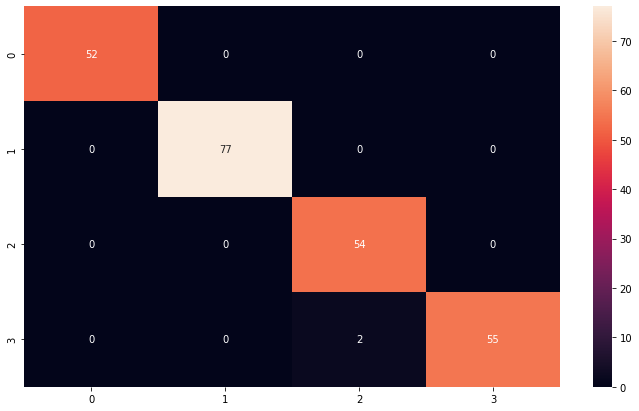

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plot

y_pred = []
y_true = []

for sample, labels in test_loader:
    sample = sample.to(device=device, dtype=torch.float)
    labels = labels.to(device=device, dtype=torch.float)

    output = net(sample)

    output = (torch.max(output, 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    labels = (torch.max(labels,1)[1]).data.cpu().numpy()
    y_true.extend(labels) # Save Truth

classes = (0,1,2,3)

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plot.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plot.show()


## Live test


In [10]:
import ifxdaq
import processing
import numpy as np
#print(ifxdaq.__version__)
from ifxdaq.sensor.radar_ifx import RadarIfxAvian
import matplotlib.pyplot as plot
from matplotlib.animation import FuncAnimation
import torch
device = "cuda"
config_file = "radar_configs/RadarIfxBGT60.json"

In [12]:
import cv2

with RadarIfxAvian(config_file) as radar:                             # Initialize the radar with configurations
    
    for i_frame, frame in enumerate(radar):                           # Loop through the frames coming from the radar
        data = np.squeeze(frame['radar'].data)      
        data = np.asarray([data])
        range_doppler_map = processing.processing_rangeDopplerData(data)
        data = np.abs(range_doppler_map)
        input = torch.tensor(data).to(device=device, dtype=torch.float32)

        no = torch.argmax(net(input))
        # no = 1 #TODO:Remove
        # img = np.concatenate((data[0,0,:,:],data[0,1,:,:],data[0,2,:,:] ))
        
        # # scale the image
        # scale_percent = 400 # percent of original size
        # width = int(img.shape[1] * scale_percent / 100)
        # height = int(img.shape[0] * scale_percent / 100)
        # dim = (width, height)

        # img = cv2.resize(img, dim)
        # print(img.shape)
        # text = np.ones(shape=(256, 256), dtype=np.int16)
        # cv2.putText(text, text=f"{no}", org=(30, 100), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
        #     fontScale=8, color=(255, 0, 0),thickness=3)
        
        # cv2.imshow("img",img)
        # cv2.imshow("text",text)
        print(no)
        # cv2.imshow("status", img)


tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
t

KeyboardInterrupt: 